In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [5]:
df = pd.read_csv('marketing_campaign.csv', sep = '\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [21]:
#1
from typing import List
import numpy as np

def clean_and_encode_data(
    df: pd.DataFrame,
    numerical_cols: List[str] = ['Income'],
    categorical_cols: List[str] = ['Education', 'Marital_Status'],
    date_col: str = 'Dt_Customer',
    birth_col: str = 'Year_Birth',
    reference_year: int = 2024
) -> pd.DataFrame:
    for col in numerical_cols:
        df[col] = df[col].fillna(df[col].median())

    df[date_col] = pd.to_datetime(df[date_col], format='%d-%m-%Y', errors='coerce')
    
    df['Age'] = reference_year - df[birth_col]
    
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    df_encoded = df_encoded.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    return df_encoded

df_encoded = clean_and_encode_data(df)
df_encoded.head() 


#I replaced missing values with the median in numeric columns. The date column was originally in string format, and it needed to be converted into datetime type. What's more, considering a fixed reference year, I created an Age column based on birth year. Afterwards, one-hot encoding was performed for categorical columns. To be on the safe side, I replaced zero with any possible infinity or residual NaNs. After normalizing the data, all numeric columns were transformed into integers whenever possible.

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,5524,1957,58138.0,0,0,2012-09-04,58,635,88,546,...,True,False,False,False,False,False,True,False,False,False
1,2174,1954,46344.0,1,1,2014-03-08,38,11,1,6,...,True,False,False,False,False,False,True,False,False,False
2,4141,1965,71613.0,0,0,2013-08-21,26,426,49,127,...,True,False,False,False,False,False,False,True,False,False
3,6182,1984,26646.0,1,0,2014-02-10,26,11,4,20,...,True,False,False,False,False,False,False,True,False,False
4,5324,1981,58293.0,1,0,2014-01-19,94,173,43,118,...,False,False,True,False,False,True,False,False,False,False


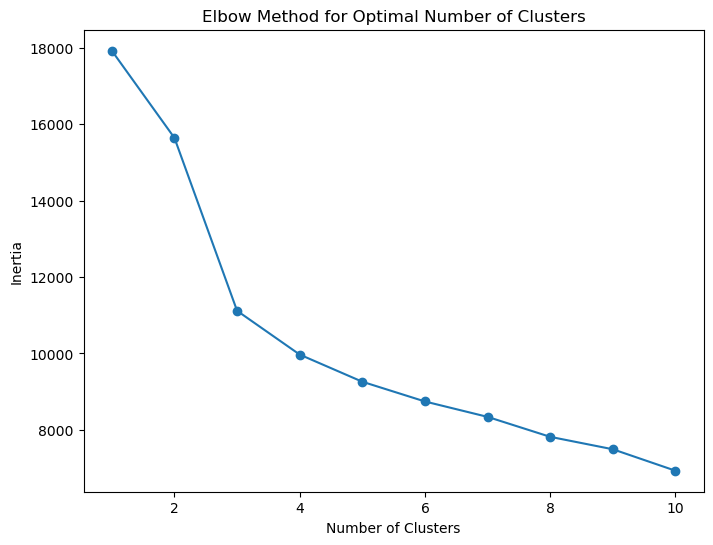

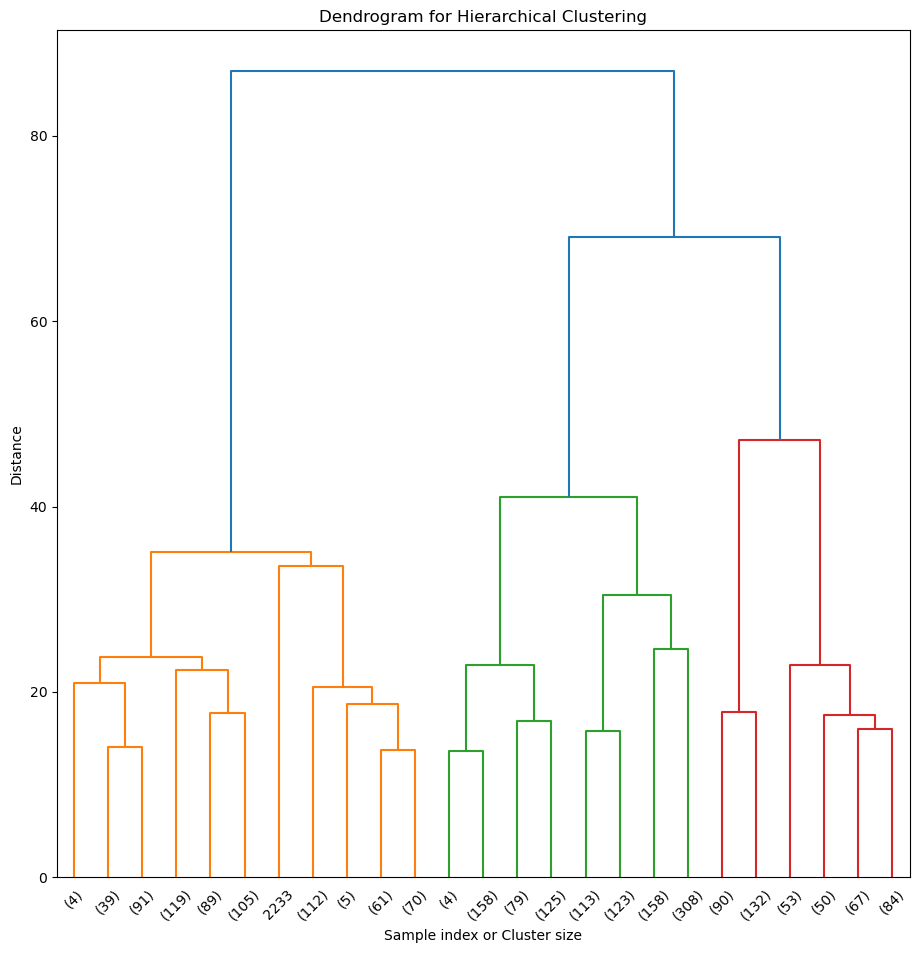

In [17]:
#3
def plot_dendrogram(df_encoded):
    features = [
        'Age', 'Income', 'Recency', 'MntWines', 'MntMeatProducts', 
        'NumWebPurchases', 'NumStorePurchases', 'Marital_Status_Single'
    ]

    X = df_encoded[features]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    linked = linkage(X_scaled, method='ward')

    plt.figure(figsize=(11, 11))
    dendrogram(linked, truncate_mode='lastp', p=25)
    plt.xlabel("Sample index or Cluster size")
    plt.ylabel("Distance")
    plt.title("Dendrogram for Hierarchical Clustering")
    plt.show()

plot_dendrogram(df_encoded)

#Discarding all data indiscriminately is usually not appropriate. In turn, selection of a meaningful feature subset-like age, income, key heads of spending, and purchase frequencies-defines clusters that can explain distinct customer segments. Too many features might bring noise and water down the meaningful patterns. I then applied the elbow method to estimate an optimal value for k for the k-means algorithm and scatter-plotted inertia, the sum of squared distances against the number of clusters. Often, the ideal number of clusters is where the plot shows a sharp "elbow," which in this case is around 3-4.

In [ ]:
#While K-means showed that the ideal cluster number was 3, hierarchical clustering suggested it to be 5. Of the two, I believe that K-means fits the best, since it's rather faster and more efficient, at least in the case of big datasets. Using the elbow method of finding a number of clusters with K-means, I can bring my focus onto key customer features and easily adjust the cluster number to get the best segmentation. This technique gives well-defined and clear clusters, which are good in targeting customer groups. Besides, hierarchical clustering needed some tuning since initially, it was very messy and generally harder to interpret.